In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV,cross_val_score,train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import tensorflow as tf
from tensorflow import python
from tensorflow import metrics

import warnings
warnings.filterwarnings('ignore')

# np.random.seed(1)
plt.style.use('ggplot')

In [2]:
df = pd.read_csv(r'./dataset/air_quality_health_impact_data.csv')


In [3]:
def style_dataframe(df):
    """
    Applies a unique styling to the entire DataFrame with different colors and visual elements.
    """
    df = df.copy()  # Avoid SettingWithCopyWarning
    
    # Apply unique styling to the entire DataFrame
    styled_df = df.style.set_table_styles(
        [
            {
                'selector': 'thead th',
                'props': [
                    ('font-family','Arial, sans-serif'),  # Changed font to Arial
                    ('background-color', '#4F9D9D'),  # New header background color
                    ('color', '#FFFFFF'),             # Header text color updated
                    ('font-weight', 'bold'),
                    ('text-align', 'center'),
                    ('border', '2px solid #77B8B8'),  # Darker border for header
                    ('padding', '10px')
                    ]            
            },
            {
                'selector': 'tbody td',
                'props': [ 
                    ('font-family','Verdana, sans-serif'),  # Changed body font to Verdana
                    ('background-color', '#F1F1F1'),  # Light grey background for body
                    ('border', '1px solid #77B8B8'),  # Matching body border with header
                    ('font-weight', 'normal'),
                    ('color', '#2C3E50'),             # Darker text color for readability
                    ('padding', '8px')    ]
            }
        ]
    ).set_properties(
        **{'text-align': 'center'}
    ).format(precision=2)  # Set decimal precision to 2 for all float columns
    
    display(styled_df)


In [4]:
df.shape

(5811, 15)

In [5]:
style_dataframe(df.head())

,RecordID,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactScore,HealthImpactClass
0,1,187.27,295.85,13.04,6.64,66.16,54.62,5.15,84.42,6.14,7,5,1,97.24,0.00
1,2,475.36,246.25,9.98,16.32,90.50,169.62,1.54,46.85,4.52,10,2,0,100.00,0.00
2,3,366.00,84.44,23.11,96.32,17.88,9.01,1.17,17.81,11.16,13,3,0,100.00,0.00
3,4,299.33,21.02,14.27,81.23,48.32,93.16,21.93,99.47,15.30,8,8,1,100.00,0.00
4,5,78.01,16.99,152.11,121.24,90.87,241.80,9.22,24.91,14.53,9,0,1,95.18,0.00


In [6]:
categorical_features = df.select_dtypes(include='object').columns.tolist()

numerical_features = df.select_dtypes(exclude='object').columns.tolist()

for feature in ['HealthImpactScore', 'RecordID','HealthImpactClass']:
    if feature in numerical_features:
        numerical_features.remove(feature)

# Create DataFrames for continuous and categorical variables

df_numerical = pd.DataFrame({'Numerical Variables': numerical_features})
df_categorical = pd.DataFrame({'Categorical Variables': categorical_features})

styled_numerical_df = style_dataframe(df_numerical)
styled_numerical_df

,Numerical Variables
0,AQI
1,PM10
2,PM2_5
3,NO2
4,SO2
5,O3
6,Temperature
7,Humidity
8,WindSpeed
9,RespiratoryCases


In [7]:
styled_categorical_df = style_dataframe(df_categorical)
styled_categorical_df

,Categorical Variables


In [8]:
df_null_sum = df.isnull().sum().to_frame(name='Missing Values')
style_dataframe(df_null_sum)

,Missing Values
RecordID,0
AQI,0
PM10,0
PM2_5,0
NO2,0
SO2,0
O3,0
Temperature,0
Humidity,0
WindSpeed,0


In [9]:
def count_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers)


In [10]:
outliers = []
for index, col in enumerate(numerical_features):
    column_data = numerical_features[index]
    outliers.append({
        'Feature' : col,
        'Num of outliers' : count_outliers(col)
    })
style_dataframe(pd.DataFrame(outliers))

,Feature,Num of outliers
0,AQI,0
1,PM10,0
2,PM2_5,0
3,NO2,0
4,SO2,0
5,O3,0
6,Temperature,0
7,Humidity,0
8,WindSpeed,0
9,RespiratoryCases,42


In [11]:
custom_palette = ['#C0C78C','#B99470','#FEFAE0',  '#A6B37D']

# Set the custom palette in seaborn
sns.set_palette(custom_palette)

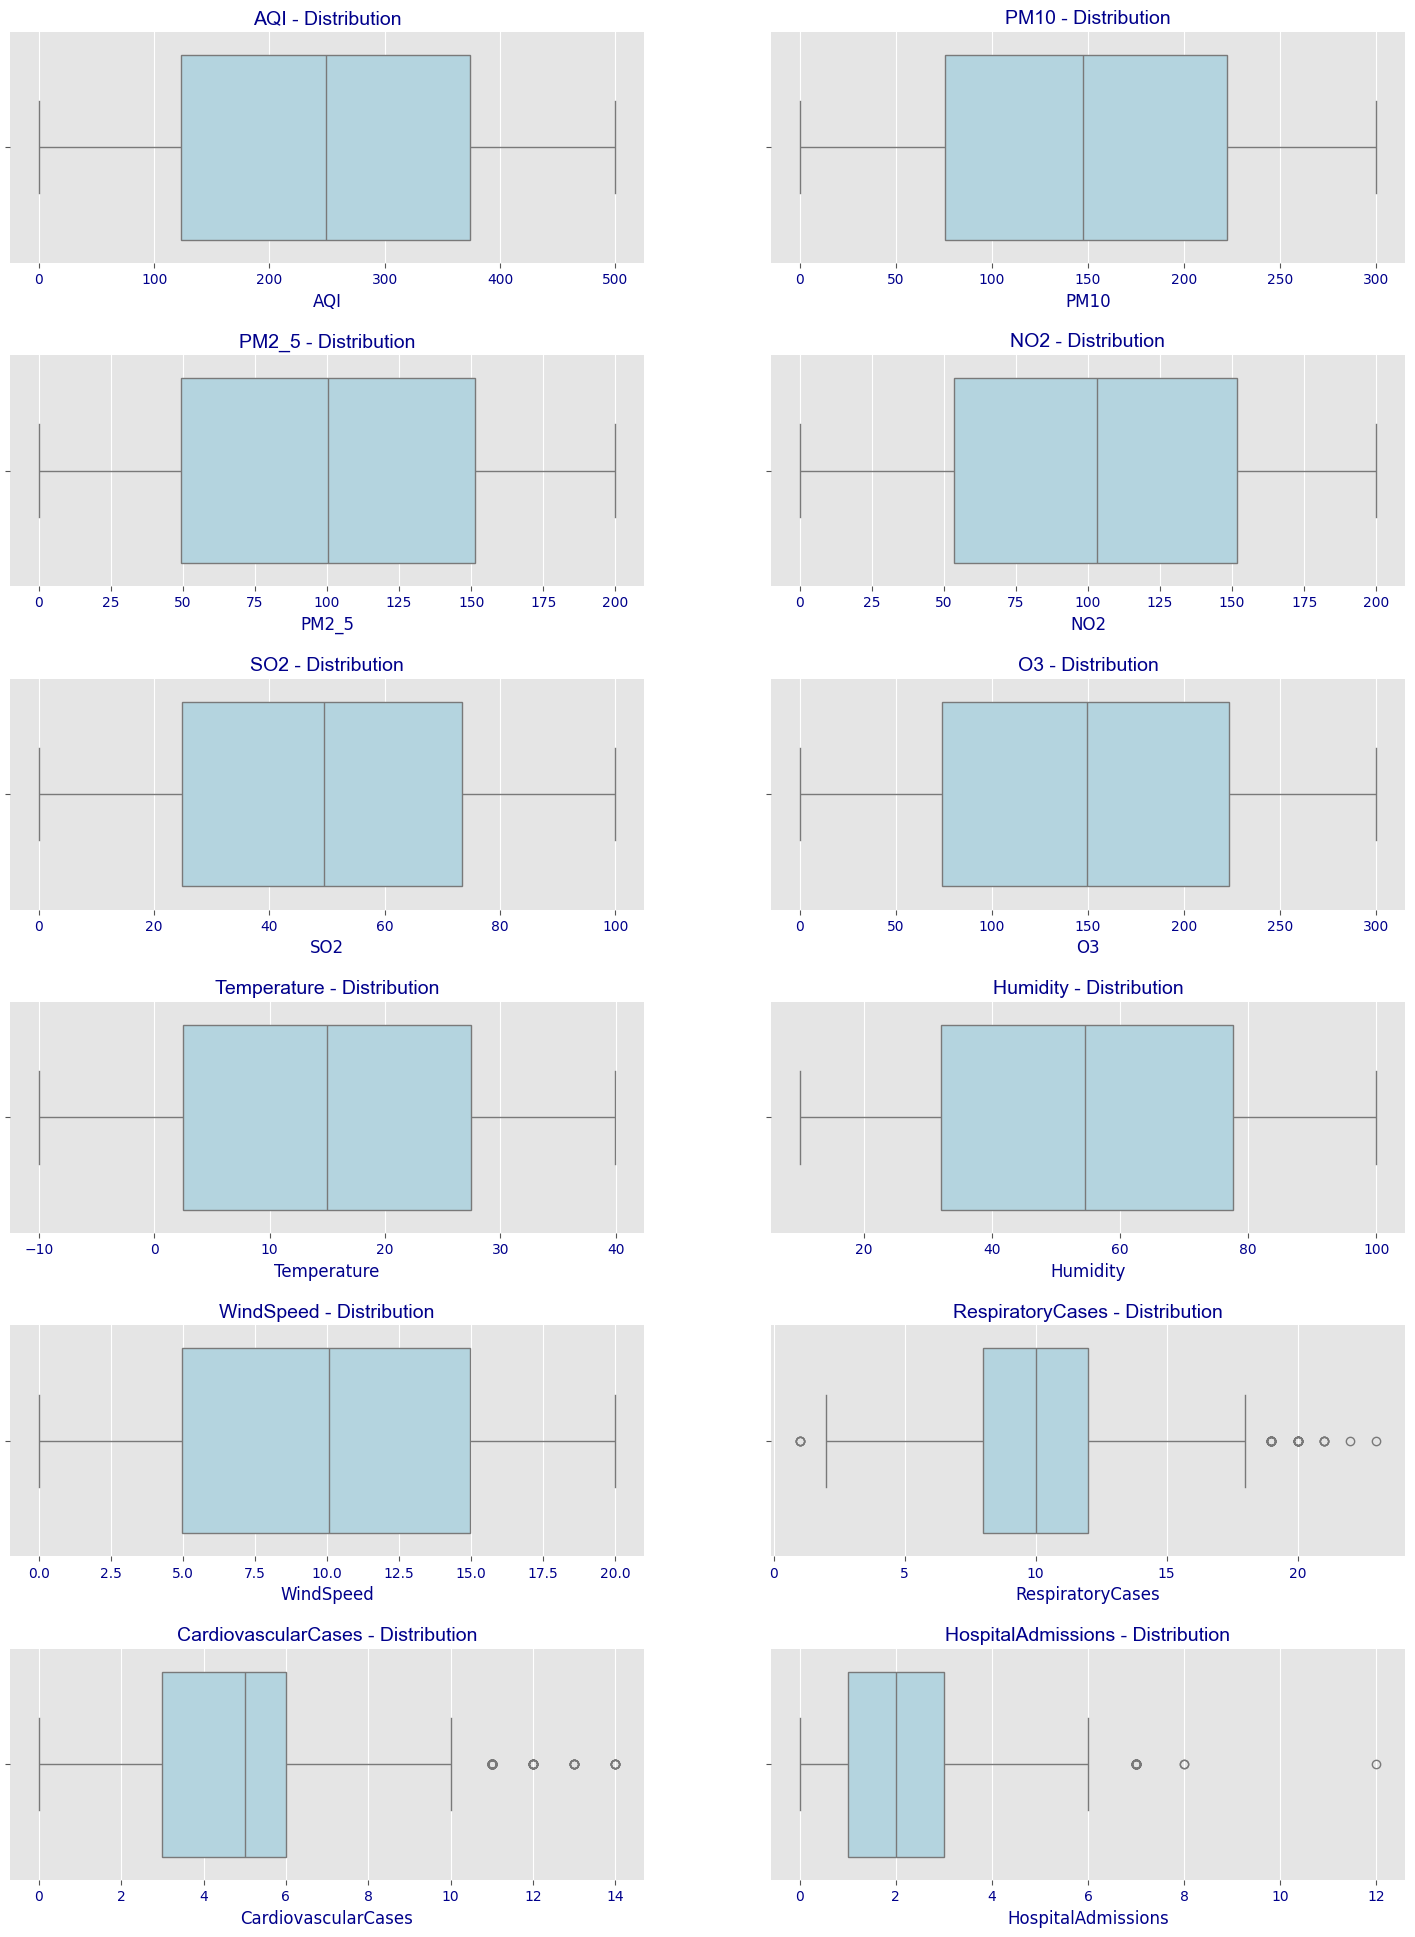

In [12]:
num_cols = len(numerical_features)
columns = 2  # Number of columns for subplots
rows = -(-num_cols // columns)  # Calculate rows with ceiling division

fig, axes = plt.subplots(rows, columns, figsize=(18, rows * 4))  # Adjusted figure size
axes = axes.flatten()

for idx, feature in enumerate(numerical_features):
    sns.boxplot(data=df, x=feature, ax=axes[idx], color='lightblue')  # Set boxplot color to blue
    
    axes[idx].set_title(
        f'{feature} - Distribution',
        fontdict={'family': 'Arial', 'color': 'darkblue', 'fontsize': 14, 'fontweight': 'medium'}
    )
    
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].spines['left'].set_visible(False)
    axes[idx].spines['bottom'].set_visible(False)

    # Customize ticks and labels
    axes[idx].tick_params(axis='x', labelcolor='darkblue')
    axes[idx].tick_params(axis='y', labelcolor='darkblue')
    axes[idx].xaxis.label.set_color('darkblue')
    axes[idx].yaxis.label.set_color('darkblue')

# Hide any extra subplots not used
for extra_idx in range(len(numerical_features), len(axes)):
    axes[extra_idx].set_visible(False)

plt.subplots_adjust(hspace=0.4)  # Adjust spacing between plots
plt.show()


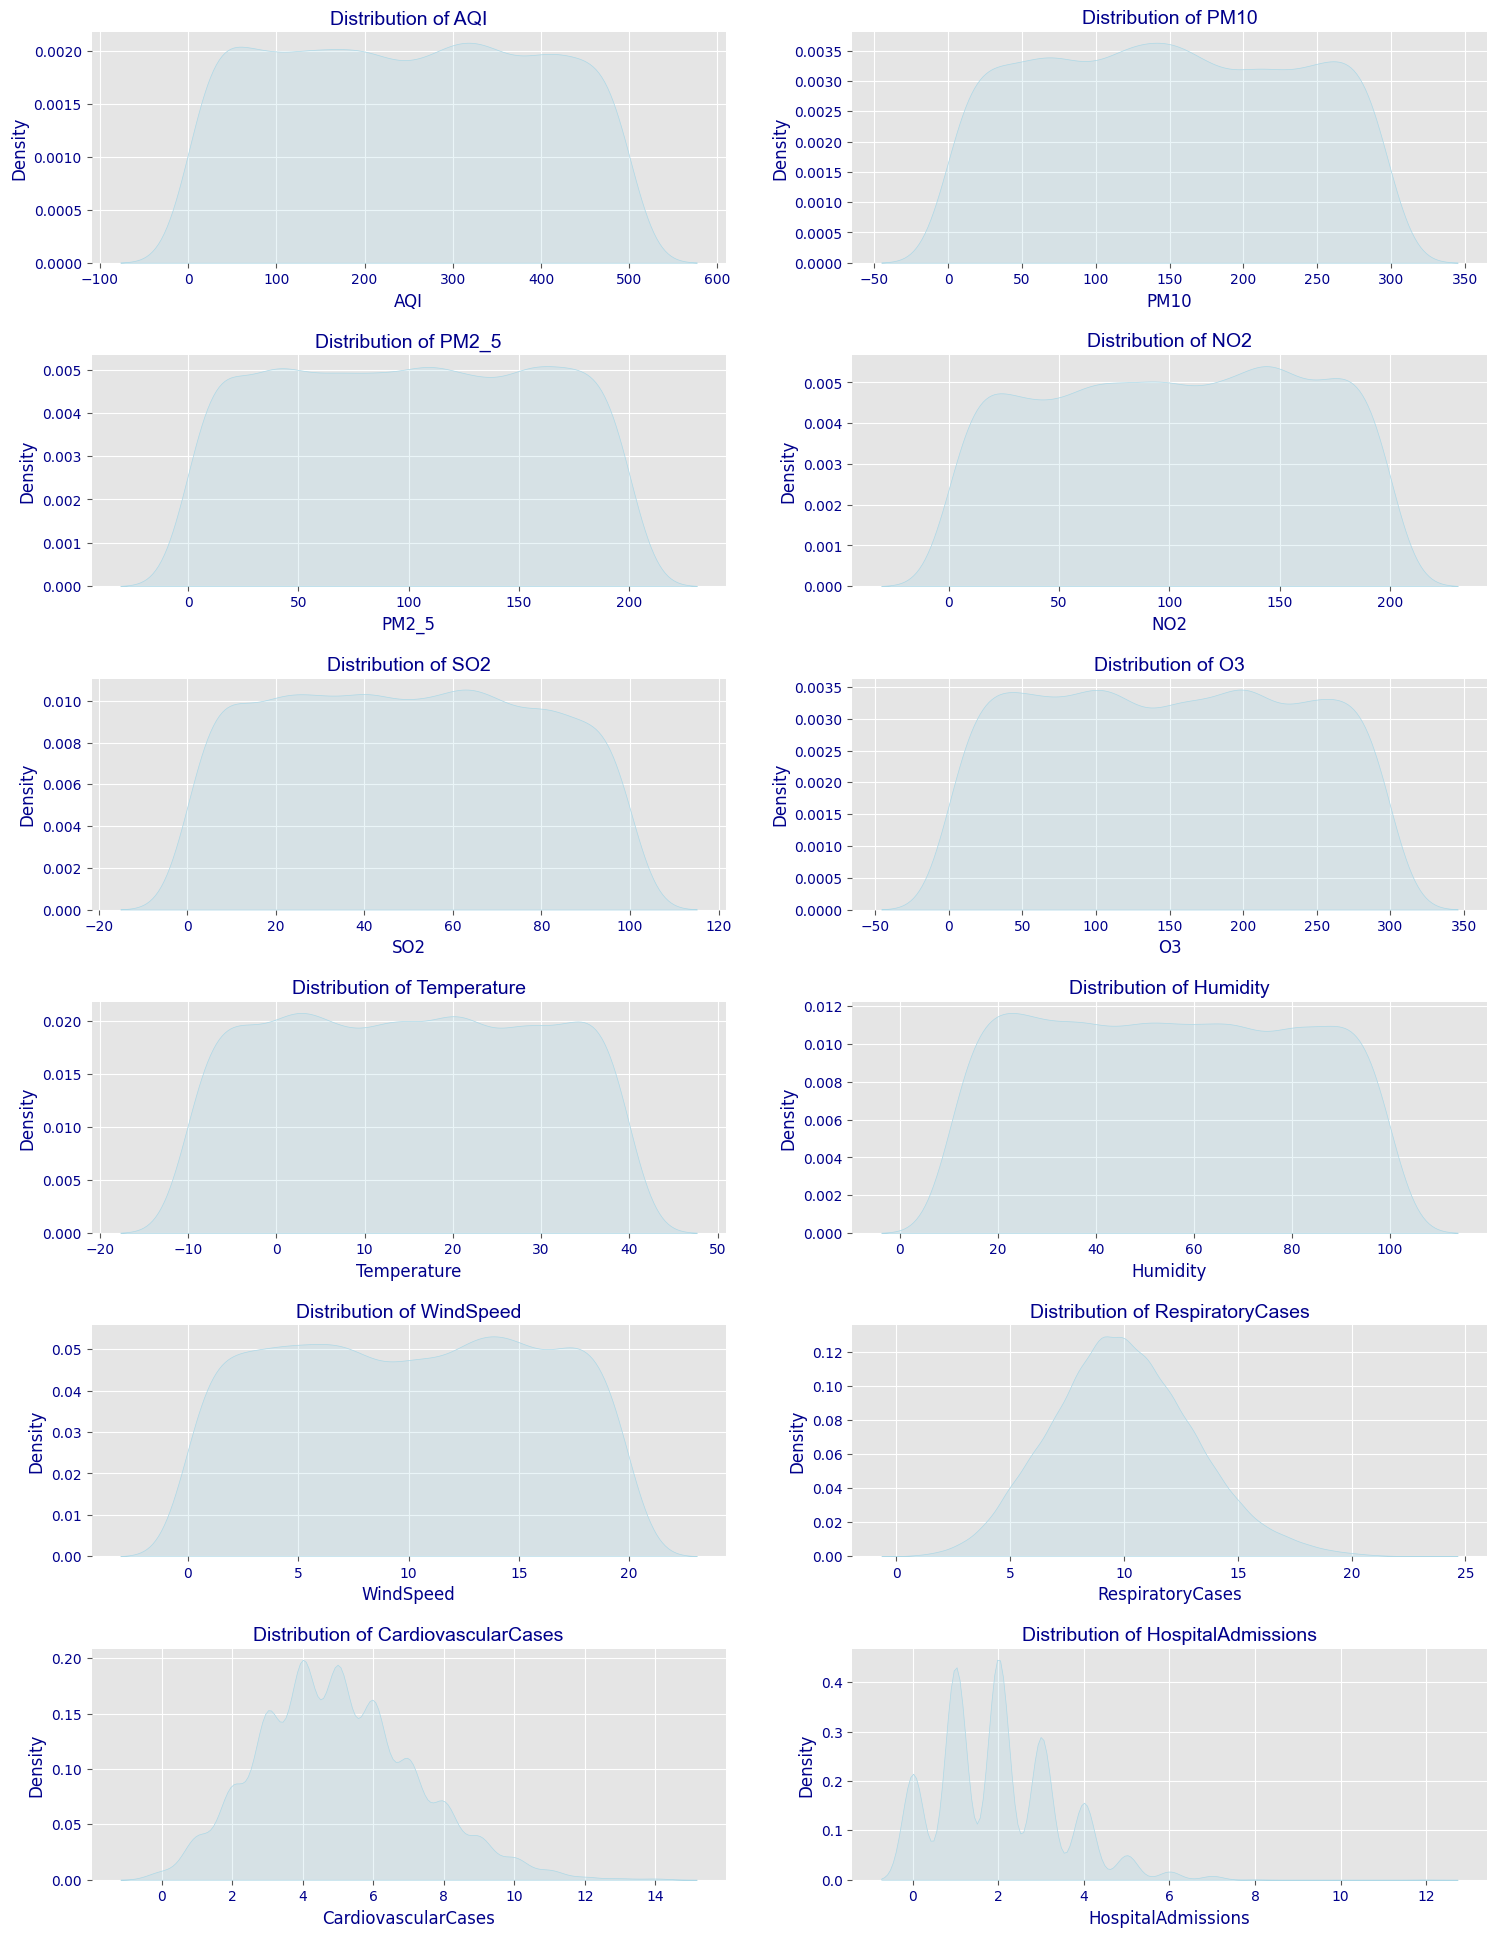

In [13]:
num_cols = len(numerical_features)
columns = 2  # Number of columns for subplots
rows = -(-num_cols // columns)  # Calculate rows with ceiling division

fig, axes = plt.subplots(rows, columns, figsize=(18, rows * 4))  # Adjusted figure size
axes = axes.flatten()

for idx, feature in enumerate(numerical_features):
    sns.kdeplot(data=df, x=feature, ax=axes[idx], fill=True, color='lightblue')  # Changed color to light blue

    axes[idx].set_title(
        f'Distribution of {feature}',
        fontdict={'family': 'Arial', 'color': 'darkblue', 'fontsize': 14, 'fontweight': 'medium'}
    )

    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].spines['left'].set_visible(False)
    axes[idx].spines['bottom'].set_visible(False)

    # Customize ticks and labels
    axes[idx].tick_params(axis='x', labelcolor='darkblue')
    axes[idx].tick_params(axis='y', labelcolor='darkblue')
    axes[idx].xaxis.label.set_color('darkblue')
    axes[idx].yaxis.label.set_color('darkblue')

# Hide any extra subplots not used
for extra_idx in range(len(numerical_features), len(axes)):
    axes[extra_idx].set_visible(False)

plt.subplots_adjust(hspace=0.4)  # Adjust spacing between plots
plt.show()

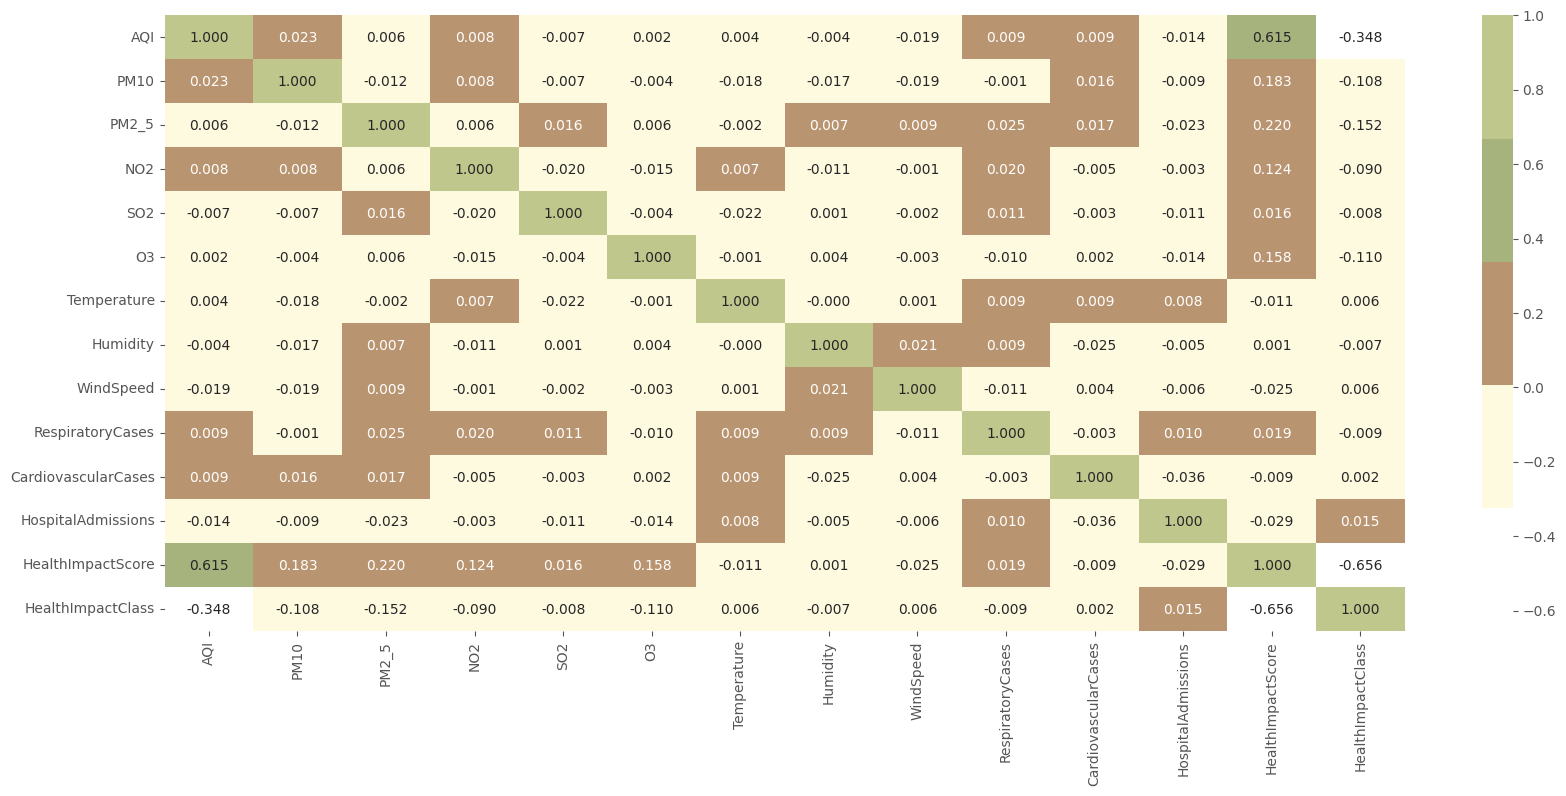

In [14]:
plt.figure(figsize=(20, 8))
num_deatures = df.select_dtypes(exclude='object').columns.tolist()
num_deatures.remove('RecordID')
corr_matrix = df[num_deatures].corr()
sns.heatmap(corr_matrix, annot=True,cmap= ['#ffffff','#FEFAE0','#B99470',  '#A6B37D', '#C0C78C'], fmt='.3f')
plt.show()

##DATA CLEANING

In [15]:
# Hapus kolom dengan metode tanpa inplace
df = df.drop(columns=['RecordID', 'RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions'], errors='ignore')
print(df.columns.tolist())


['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity', 'WindSpeed', 'HealthImpactScore', 'HealthImpactClass']


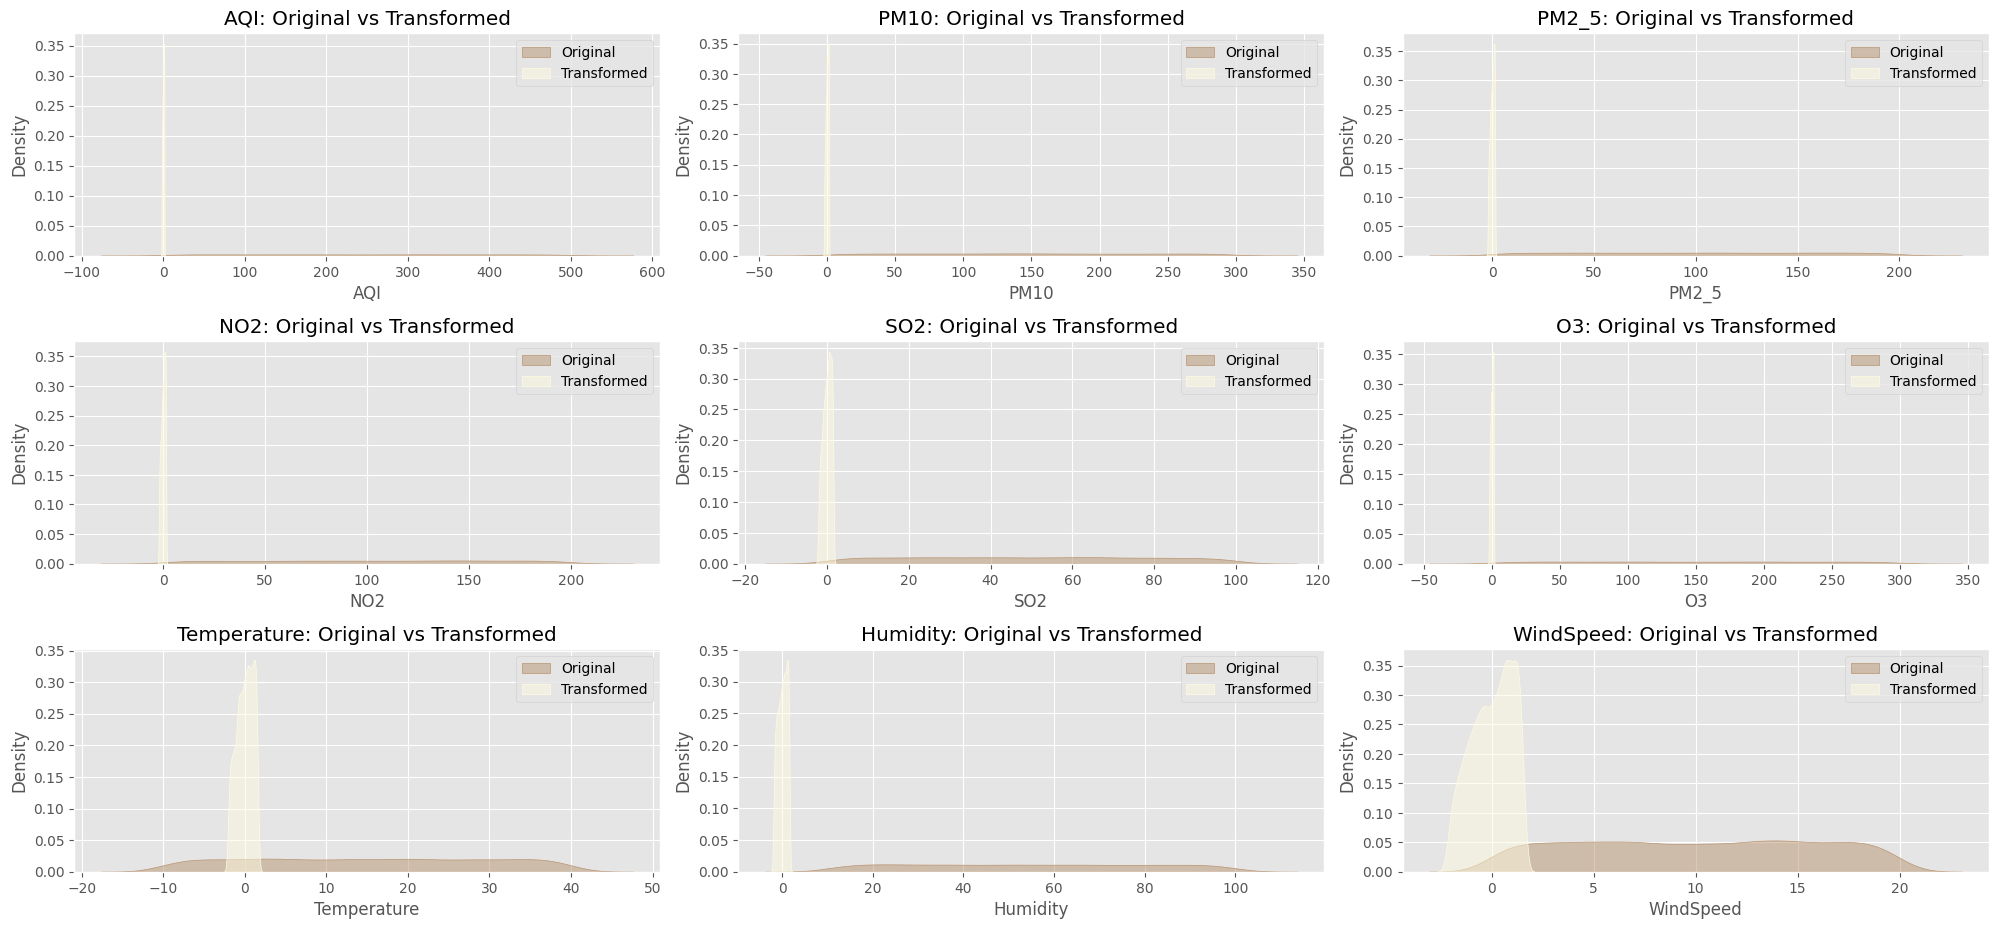

In [16]:
from sklearn.preprocessing import PowerTransformer

# Identifying features to transform
features = ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 
            'Humidity', 'WindSpeed']

# Handle non-positive values by adding a constant
df_transformed = df.copy()

for feature in features:
    # If there are any non-positive values, apply Yeo-Johnson
    if (df[feature] <= 0).any():
        pt = PowerTransformer(method='yeo-johnson')
        df_transformed[feature] = pt.fit_transform(df[[feature]])
    else:
        # For positive-only values, use Box-Cox transformation
        pt = PowerTransformer(method='box-cox')
        df_transformed[feature] = pt.fit_transform(df[[feature]])

# Plotting the original vs transformed data
plt.figure(figsize=(20, 12))
for i, feature in enumerate(features):
    plt.subplot(4, 3, i + 1)
    sns.kdeplot(df[feature], label='Original', alpha=0.5,fill=True, color='#B99470')
    sns.kdeplot(df_transformed[feature], label='Transformed', alpha=0.5,fill=True,color='#FEFAE0' )
    plt.title(f'{feature}: Original vs Transformed')
    plt.legend()

plt.tight_layout()
plt.show()


##MODELING

In [17]:
def plot_loss(loss,val_loss):
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'],loc='upper right')
    plt.show()

def plot_acc(acc,val_acc):
    plt.figure()
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'],loc='upper right')
    plt.show()

In [18]:
X = df.drop(columns=['HealthImpactScore','HealthImpactClass'])
y = df['HealthImpactScore']

In [19]:
X_train ,X_test ,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [20]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

In [21]:
print("Shape X_train_scaled:", X_train_scaled.shape)
print("Shape X_test_scaled:", X_test_scaled.shape)

Shape X_train_scaled: (4648, 9)
Shape X_test_scaled: (1163, 9)


In [22]:
model=Sequential()

In [23]:
dl_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),  # Sesuaikan input shape
    tf.keras.layers.Dense(units=90, activation='tanh'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=70, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=30, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=10, activation='sigmoid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

In [24]:
dl_model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 90)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 90)             │           360 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 70)             │         6,370 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 70)             │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         3,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,521 (52.82 KB)

 Trainable params: 13,121 (51.25 KB)

 Non-trainable params: 400 (1.56 KB)

In [25]:
dl_model_1.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'mse',
    metrics = ['mae']
)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


In [27]:
history = dl_model_1.fit(
    x = X_train_scaled,
    y= y_train,
    validation_data = (X_test_scaled,y_test),
    epochs = 100,
    callbacks=[early_stop]
)

Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8762.8037 - mae: 92.7339 - val_loss: 8283.1689 - val_mae: 90.0953
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7931.1440 - mae: 88.1939 - val_loss: 6620.6382 - val_mae: 80.4761
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6356.5337 - mae: 78.7527 - val_loss: 4197.0195 - val_mae: 63.7096
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3962.6968 - mae: 61.5857 - val_loss: 2197.4487 - val_mae: 44.1330
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1866.9320 - mae: 40.5859 - val_loss: 805.7961 - val_mae: 24.1316
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 749.8703 - mae: 24.1557 - val_loss: 338.4360 - val_mae: 14.1652
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 351.0981 - mae: 14.6040 - val_loss: 275.7727 - val_mae: 11.2010
Epoch 8/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 331.2483 - mae: 12.5131 - val_loss: 240.1825 - val_mae:

In [28]:
test_loss = dl_model_1.evaluate(X_test_scaled,y_test)
print(f"Test Loss(MSE) : {test_loss}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 3.3836 - mae: 0.9404
Test Loss(MSE) : [3.6807119846343994, 0.9376646876335144]


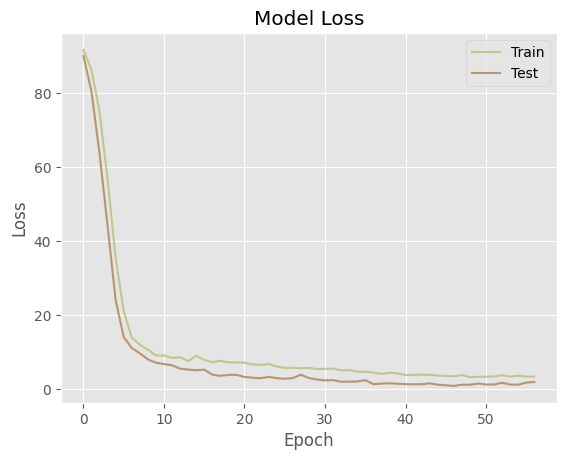

In [29]:
plot_loss(history.history['mae'],history.history['val_mae'])

In [30]:
y_pred = dl_model_1.predict(X_test_scaled)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [31]:
print(f"MSE : {mean_squared_error(y_test,y_pred)}")
print(f"MAE : {mean_absolute_error(y_test,y_pred)}")
print(f"R2 Score : {r2_score(y_test,y_pred)}")

MSE : 3.6807119074267787
MAE : 0.9376646817912586
R2 Score : 0.9803554965567265


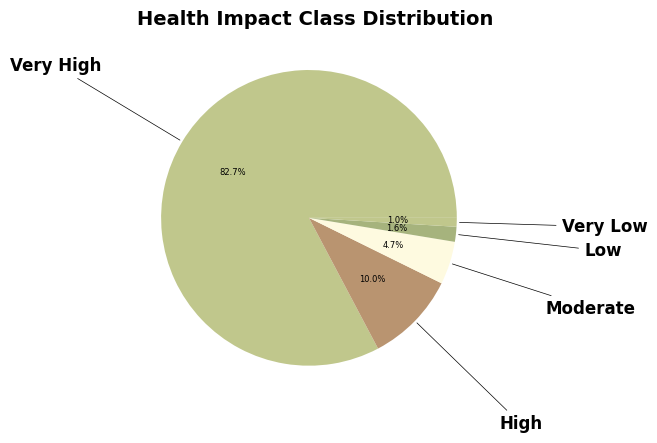

In [32]:
fig, ax = plt.subplots()

# Explode each slice slightly for emphasis
explode = [0.05, 0.05, 0.05, 0.05, 0.05]

# Plot pie chart
wedges, texts, autotexts = ax.pie(
    df['HealthImpactClass'].value_counts(), 
    autopct='%1.1f%%', 
    colors=custom_palette, 
    # wedgeprops=dict(edgecolor='white', linewidth=1.5)
)

# Adding title and formatting it
plt.title('Health Impact Class Distribution', color='black', fontsize=14, fontweight='bold',loc='right')

# Remove the y-axis label
plt.ylabel('')

# Make the percentage text larger and bolder
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(6)
# Add annotations with arrows pointing to wedges
categories = ['Very High', 'High', 'Moderate', 'Low', 'Very Low']

for i, wedge in enumerate(wedges):
    # Get the angle and position for each wedge
    angle = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
    x = wedge.r * np.cos(np.radians(angle))
    y = wedge.r * np.sin(np.radians(angle))

    # Define the annotation position
    xtext = x * 2  # Position label further outside the pie chart
    ytext = y * 2

    # Add annotation with an arrow
    ax.annotate(
        categories[i], 
        xy=(x, y),  # Position at the wedge
        xytext=(xtext, ytext),  # Position of the label outside the pie chart
        ha='center', va='center', fontsize=12, fontweight='bold',
        arrowprops=dict(arrowstyle="-", color='black', lw=.5)  # Arrow pointing from wedge to label
    )

# Show the plot
plt.show()

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
# Memisahkan fitur (X) dan target (y)
X = df[['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity', 'WindSpeed']].values
y = df['HealthImpactScore'].values

In [35]:
# Normalisasi data menggunakan MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
# Reshape data untuk CNN (menambahkan dimensi channel)
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

In [37]:
# Membagi dataset menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [38]:
# Membuat model CNN
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),  # Input layer
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Output layer
])

In [39]:
# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [40]:
# Menambahkan Early Stopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Melatih model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5235.2881 - mae: 62.3232 - val_loss: 225.2295 - val_mae: 11.7756
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 235.9749 - mae: 11.9888 - val_loss: 169.2758 - val_mae: 10.4070
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 189.3677 - mae: 10.4412 - val_loss: 139.1213 - val_mae: 7.3437
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160.3170 - mae: 9.4220 - val_loss: 118.8962 - val_mae: 8.4392
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 154.2668 - mae: 9.4198 - val_loss: 94.3338 - val_mae: 7.1516
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 129.5040 - mae: 8.7543 - val_loss: 91.4792 - val_mae: 7.6253
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.6689 - mae: 8.5256 - val_loss: 82.6059 - val_mae: 7.3251
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 107.0385 - mae: 8.2564 - val_loss: 63.0491 - val_mae: 6.2567
Epoch 9/100
11

In [42]:
# Evaluasi model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 2.9556429386138916


In [43]:
# Fungsi prediksi
def predict_health_impact_cnn(aqi, pm10, pm2_5, no2, so2, o3, temperature, humidity, wind_speed):
    """
    Fungsi untuk memprediksi HealthImpactScore menggunakan CNN.
    """
    input_data = np.array([[aqi, pm10, pm2_5, no2, so2, o3, temperature, humidity, wind_speed]])
    input_data_scaled = scaler.transform(input_data)  # Normalisasi data
    input_data_scaled = input_data_scaled.reshape(input_data_scaled.shape[0], input_data_scaled.shape[1], 1)  # Reshape untuk CNN
    return model.predict(input_data_scaled)[0][0]

In [44]:
# Contoh penggunaan fungsi
predicted_score = predict_health_impact_cnn(187.2700594, 295.8530392, 13.03856044, 6.639263013, 66.16114965, 54.62427998, 5.150335038, 84.42434365, 6.137755447)
print("Predicted HealthImpactScore:", predicted_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted HealthImpactScore: 97.268524


In [45]:
from sklearn.metrics import r2_score, mean_absolute_error

# Prediksi pada data train
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step


In [46]:
# Evaluasi pada train set
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

In [47]:
# Evaluasi pada test set
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

In [48]:
print("=== Evaluasi Model ===")
print(f"Train Set R-squared: {r2_train:.4f}")
print(f"Train Set MAE: {mae_train:.4f}")
print(f"Test Set R-squared: {r2_test:.4f}")
print(f"Test Set MAE: {mae_test:.4f}")

=== Evaluasi Model ===
Train Set R-squared: 0.9201
Train Set MAE: 2.8138
Test Set R-squared: 0.9181
Test Set MAE: 2.9556


In [49]:
print("\n=== Akurasi ===")
if r2_test >= 0.9:
    print("Model memiliki akurasi sangat tinggi pada test set (R² > 0.9).")
elif r2_test >= 0.8:
    print("Model memiliki akurasi baik pada test set (R² antara 0.8 dan 0.9).")
elif r2_test >= 0.7:
    print("Model memiliki akurasi sedang pada test set (R² antara 0.7 dan 0.8).")
else:
    print("Model memiliki akurasi rendah pada test set (R² < 0.7).")

if abs(r2_train - r2_test) > 0.1:
    print("Namun, terdapat perbedaan signifikan antara performa train dan test set, kemungkinan terjadi overfitting.")
else:
    print("Performa model pada train dan test set konsisten, tidak ada indikasi overfitting.")


=== Akurasi ===
Model memiliki akurasi sangat tinggi pada test set (R² > 0.9).
Performa model pada train dan test set konsisten, tidak ada indikasi overfitting.


In [50]:
def classify_health_impact(score):
    """
    Mengklasifikasikan HealthImpactScore ke dalam kategori.
    """
    if score <= 20:
        return "Sehat (Healthy)"
    elif score <= 50:
        return "Sedang (Moderate)"
    elif score <= 100:
        return "Tidak Sehat (Unhealthy)"
    elif score <= 150:
        return "Sangat Tidak Sehat (Very Unhealthy)"
    else:
        return "Berbahaya (Hazardous)"

In [51]:
# Contoh Prediksi dan Klasifikasi
predicted_score = predict_health_impact_cnn(187.2700594, 295.8530392, 13.03856044, 6.639263013, 66.16114965, 54.62427998, 5.150335038, 84.42434365, 6.137755447)
category = classify_health_impact(predicted_score)

print(f"Predicted HealthImpactScore: {predicted_score:.2f}")
print(f"Kategori: {category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted HealthImpactScore: 97.27
Kategori: Tidak Sehat (Unhealthy)
